In [43]:
import numpy as np
import pandas as pd

import math

from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers.core import Dense, Dropout, Lambda, Flatten, Reshape
from tensorflow.contrib.keras.python.keras.layers.convolutional import Conv2D, ZeroPadding2D
from tensorflow.contrib.keras.python.keras.layers.pooling import MaxPooling2D
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization
from tensorflow.contrib.keras.python.keras.regularizers import l2
from tensorflow.contrib.keras.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.contrib.keras.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.contrib.keras.python.keras.utils.np_utils import to_categorical
from tensorflow.contrib.keras.python.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True, palette='muted')

## Glimpse at the MNIST Data

In [2]:
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'

df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

### Getting an Overview

In [3]:
print('Training data:', df_train.info())
print('\n --- \n')
print('Test data:', df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
Training data: None

 --- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
Test data: None


In [4]:
df_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [5]:
df_test.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.164607,0.073214,0.028036,0.011250,0.006536,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.473293,3.616811,1.813602,1.205211,0.807475,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,254.000000,193.000000,187.000000,119.000000,0.0,0.0,0.0,0.0,0.0


In [6]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df_train.tail()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41999,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Splitting into Features and Labels

In [8]:
y_train = to_categorical(df_train['label'].values)
X_train = df_train.drop('label', axis=1).values
X_test = df_test.values

n_features = len(X_train[0])
n_pixels = int(math.sqrt(n_features))
n_classes = y_train.shape[1]

print('We\'ve got {} feature rows and {} labels'.format(len(X_train), len(y_train)))
print('Each row has {} features'.format(len(X_train[0])))
print('and we have {} classes'.format(n_classes))
assert(len(y_train) == len(X_train))
assert(len(X_train[0] == len(X_test[0])))
assert(n_features == n_pixels**2)
print('Input images have {0} x {0} px shape'.format(n_pixels))
print('So far, so good')

We've got 42000 feature rows and 42000 labels
Each row has 784 features
and we have 10 classes
Input images have 28 x 28 px shape
So far, so good


In [9]:
X_train = X_train.reshape(X_train.shape[0], n_pixels, n_pixels, 1)
X_test = X_test.reshape(X_test.shape[0], n_pixels, n_pixels, 1)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_valid.shape:', X_valid.shape)
print('y_valid.shape:', y_valid.shape)
print('X_test.shape:', X_test.shape)

X_train.shape: (37800, 28, 28, 1)
y_train.shape: (37800, 10)
X_valid.shape: (4200, 28, 28, 1)
y_valid.shape: (4200, 10)
X_test.shape: (28000, 28, 28, 1)


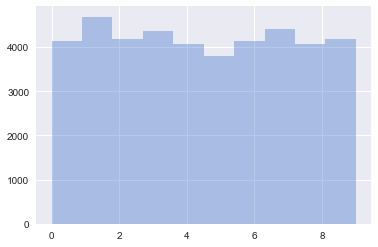

In [10]:
sns.distplot(df_train['label'].values, kde=False, vertical=False, bins=10)

In [64]:
def create_my_model(shape=(28, 28, 1)):
    
    model = Sequential()
    model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=shape))
    
    model.add(Conv2D(16, (5, 5), padding='same', activation='elu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(32, (5, 5), padding='same', activation='elu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same', activation='elu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), activation='elu'))
    
    model.add(Flatten())
    model.add(Dropout(0.7))

    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(
        optimizer=Adam(lr=0.002, decay=0.00001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model
    
model = create_my_model(shape=(n_pixels, n_pixels, 1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_24 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 7, 7, 32)          0         
__________

In [65]:
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

imgen_train = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

imgen_train.fit(X_train)

In [47]:
filepath="weights3-{epoch:02d}-{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)
callbacks_list = [checkpoint]

In [66]:
EPOCHS = 64
BATCH = 64

history = model.fit_generator(
    imgen_train.flow(*shuffle(X_train, y_train), batch_size=BATCH),
    steps_per_epoch=256,
    epochs=EPOCHS,
    validation_data=shuffle(X_valid, y_valid),
    #callbacks=callbacks_list,
    callbacks=[plateau],
    pickle_safe=False
)

Epoch 1/64
256/256 [==============================] - 3s - loss: 1.4779 - acc: 0.4885 - val_loss: 0.3011 - val_acc: 0.9190
Epoch 2/64
256/256 [==============================] - 3s - loss: 0.8371 - acc: 0.7307 - val_loss: 0.1712 - val_acc: 0.9543
Epoch 3/64
256/256 [==============================] - 3s - loss: 0.6261 - acc: 0.8069 - val_loss: 0.1424 - val_acc: 0.9583
Epoch 4/64
256/256 [==============================] - 3s - loss: 0.5693 - acc: 0.8292 - val_loss: 0.1218 - val_acc: 0.9638
Epoch 5/64
256/256 [==============================] - 3s - loss: 0.4897 - acc: 0.8499 - val_loss: 0.1043 - val_acc: 0.9690
Epoch 6/64
256/256 [==============================] - 3s - loss: 0.4570 - acc: 0.8646 - val_loss: 0.0849 - val_acc: 0.9767
Epoch 7/64
256/256 [==============================] - 3s - loss: 0.4403 - acc: 0.8677 - val_loss: 0.0955 - val_acc: 0.9729
Epoch 8/64
256/256 [==============================] - 3s - loss: 0.4092 - acc: 0.8787 - val_loss: 0.0774 - val_acc: 0.9750
Epoch 9/64
256/2

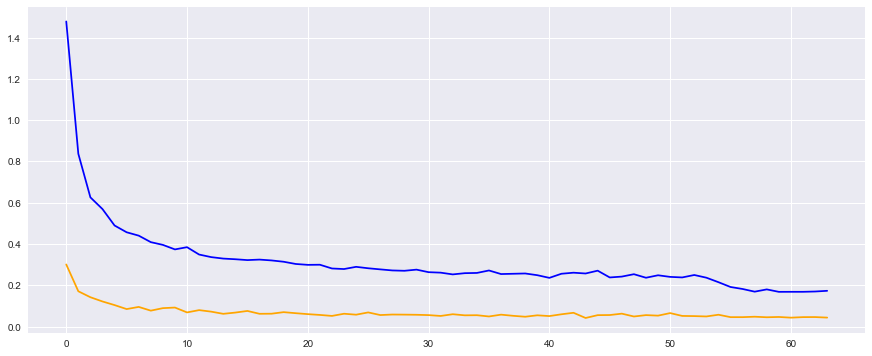

In [67]:
fig, ax = plt.subplots(figsize=(15,6))

plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='orange')

In [18]:
#model.save('model.h5')

In [27]:
model.load_weights('weights-01-1.000.hdf5')

In [68]:
y_test = model.predict_classes(X_test)
print(y_test.shape)

27808/28000 [============================>.] - ETA: 0s(28000,)


In [69]:
result = list(enumerate(y_test))
result = pd.DataFrame.from_dict({'ImageId': range(1, len(y_test)+1), 'Label': y_test})

result.to_csv('submission_20171026_5.csv', index=False)